In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [7]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [9]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, dp=0, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-4*torch.randn(nTgts,inp.shape[-1],2).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        res = []
        es = []
        x = self.dp(x)
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

print('Complete')

Complete


In [13]:
topRegions = np.zeros((10,10,2,5,2)) # Group, N, para, top5, {index, value}
topRMSE = np.zeros((10,10,3)) # Group, N, {train, val, test}

print('Complete')

Complete


In [45]:
import random

for grp in range(10):
    trainIdcs = groups[grp][0][0:496]
    validIdcs = groups[grp][0]
    testIdcs = groups[grp][1]
    
    for n in range(10):
        if n == 0:
            varArr = age_t[trainIdcs]
            varArr = [varArr, varArr]
            regs = [[], []]
        else:
            varArr = [ynback, yemoid]

        for i,var in enumerate(varArr):
#             idcs = torch.argsort(var)
#             mat = torch.cdist(var[idcs].unsqueeze(1), var[idcs].unsqueeze(1))
#             mat = torch.mean(mat) - mat
            
#             step = 200
#             Y = [nback_p_t[trainIdcs][idcs], emoid_p_t[trainIdcs][idcs]][i]

#             parts = []
#             for j in range(0,40000,step):
#                 if j >= Y.shape[1]:
#                     break
#                 part = Y[:,j:j+step]
#                 corrSim = torch.einsum('ab,db->adb', part, part)
#                 corr2 = torch.einsum('adb,ad->b', corrSim, mat)
#                 parts.append(corr2.detach().cpu().numpy())

#             parts = np.concatenate(parts)
#             idcs = np.argsort(parts)
            
#             regs[i] += [idx for idx in idcs[-5:]]
#             topRegions[grp,n,i,:,0] = idcs[-5:]
#             topRegions[grp,n,i,:,1] = parts[idcs[-5:]]
            r = None
            count = 0
            while r is None or r in regs[i]:
                if count == 5:
                    break
                r = random.randint(0,arith(263)-1)
                if r not in regs[i]:
                    count += 1
                    regs[i] += [r]
                    
            topRegions[grp,n,i,4,0] = r
            
        rnback = torch.tensor(regs[0], dtype=int)
        remoid = torch.tensor(regs[1], dtype=int)

        X0 = nback_p_t[:,rnback]
        X1 = emoid_p_t[:,remoid]
        Xreg = torch.stack([X0,X1], dim=1)

        print(rnback)
        print(remoid)

        nEpochs = 5000
        pPeriod = 200
        thresh = 50

        sim = LatSim(2, Xreg, 0.5, 0.1) # 0.2 wrat, 0.1 other
        optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

        Xt = Xreg[trainIdcs]
        Xv = Xreg[validIdcs]

        trainLoss = []
        validLoss = []

        vIdcs1 = np.arange(496,len(validIdcs))
        vIdcs2 = validIdcs[496:]
        vIdcs3 = np.concatenate([testIdcs, vIdcs2])

        var = age_t

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, _ = sim(Xt, var[trainIdcs])
            avg = torch.mean(torch.stack(res), dim=0)
            loss = 0
            for r in res + [avg]:
                loss += mseLoss(r, var[trainIdcs])
            loss = torch.stack([loss/(len(res)+1)])
            torch.sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
                print(f'epoch {epoch} loss={(float(loss))}')
                lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
                if len(validLoss) == 0 or lossV < min(validLoss):
                    print(f'New best validation epoch {epoch} loss={lossV}')
                    topRMSE[grp,n,1] = lossV
                    torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
                validLoss.append(lossV)
                if torch.all(loss[0:3] < thresh):
                    print('Early stopping')
                    break
        
        topRMSE[grp,n,0] = torch.sum(loss).detach().cpu().numpy()
        print('Finished training')

        sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
        loss = validate(sim, Xreg, var, testIdcs)
        topRMSE[grp,n,2] = loss
        print(f'FINISHED {grp} {n} {loss}')
        
        ynback = var[trainIdcs]-res[0]
        yemoid = var[trainIdcs]-res[1]
        yavg = var[trainIdcs]-avg
        
print('ALL DONE')

tensor([21453, 30472, 27868, 32298, 30909])
tensor([14448, 31983, 27311, 13717, 26818])
epoch 0 loss=1514.965576171875
New best validation epoch 0 loss=44.584468841552734
epoch 200 loss=1508.76318359375
New best validation epoch 200 loss=44.53342819213867
epoch 400 loss=1499.925048828125
New best validation epoch 400 loss=44.35356140136719
epoch 600 loss=1463.062255859375
New best validation epoch 600 loss=44.04001235961914
epoch 800 loss=1456.7655029296875
New best validation epoch 800 loss=43.64316177368164
epoch 1000 loss=1451.6063232421875
New best validation epoch 1000 loss=43.323760986328125
epoch 1200 loss=1437.9384765625
New best validation epoch 1200 loss=43.103851318359375
epoch 1400 loss=1433.675537109375
New best validation epoch 1400 loss=42.96253967285156
epoch 1600 loss=1443.7581787109375
New best validation epoch 1600 loss=42.864295959472656
epoch 1800 loss=1445.268310546875
New best validation epoch 1800 loss=42.77638244628906
epoch 2000 loss=1425.880126953125
New best

epoch 200 loss=1400.08056640625
New best validation epoch 200 loss=42.78111267089844
epoch 400 loss=1319.410888671875
New best validation epoch 400 loss=41.17200469970703
epoch 600 loss=1323.3118896484375
New best validation epoch 600 loss=40.778385162353516
epoch 800 loss=1330.853759765625
New best validation epoch 800 loss=40.47073745727539
epoch 1000 loss=1321.8226318359375
New best validation epoch 1000 loss=40.25212097167969
epoch 1200 loss=1282.978759765625
New best validation epoch 1200 loss=40.12028121948242
epoch 1400 loss=1299.459228515625
New best validation epoch 1400 loss=39.93958282470703
epoch 1600 loss=1294.9368896484375
New best validation epoch 1600 loss=39.80863571166992
epoch 1800 loss=1289.9908447265625
New best validation epoch 1800 loss=39.7999382019043
epoch 2000 loss=1202.357177734375
New best validation epoch 2000 loss=39.70452117919922
epoch 2200 loss=1253.3778076171875
New best validation epoch 2200 loss=39.69339370727539
epoch 2400 loss=1251.5908203125
epoc

epoch 4600 loss=1177.824462890625
epoch 4800 loss=1210.73779296875
epoch 4999 loss=1198.4017333984375
Finished training
FINISHED 0 7 34.63932800292969
tensor([21453, 30472, 27868, 32298, 30909,  8840, 25586,    82, 15662, 29181,
        13965, 22747,   668, 26496, 14883, 11584,  6773, 29237, 17100, 13326,
        19912,  9287,  5389,  8626, 20458, 32879,   715, 14412, 30039, 20058,
        27622, 23386, 24127, 12128, 29171, 11813, 20786, 17223,  1941,  1234,
        34696, 20560, 19667, 15013, 13523])
tensor([14448, 31983, 27311, 13717, 26818, 15188, 24769, 28412, 11955, 25431,
        22139, 23745, 16214, 10306, 31694,  3100, 11693,  3848, 21191, 16415,
         8316, 20759, 21188, 19022, 27682, 27931,  8765,  2559, 18057, 23659,
         5717,   930, 12970, 26561, 22642, 16264,   630, 25114, 11503, 16147,
        23949, 29565, 18493, 11071, 27864])
epoch 0 loss=1518.7772216796875
New best validation epoch 0 loss=44.58441162109375
epoch 200 loss=1359.158447265625
New best validation e

epoch 1800 loss=1324.90966796875
New best validation epoch 1800 loss=40.65116882324219
epoch 2000 loss=1333.7294921875
New best validation epoch 2000 loss=40.59654998779297
epoch 2200 loss=1295.1319580078125
New best validation epoch 2200 loss=40.53187942504883
epoch 2400 loss=1323.0989990234375
epoch 2600 loss=1323.052734375
epoch 2800 loss=1325.386962890625
epoch 3000 loss=1318.428466796875
New best validation epoch 3000 loss=40.5144157409668
epoch 3200 loss=1299.0667724609375
epoch 3400 loss=1314.5164794921875
epoch 3600 loss=1330.2763671875
New best validation epoch 3600 loss=40.513710021972656
epoch 3800 loss=1333.3616943359375
epoch 4000 loss=1313.02392578125
New best validation epoch 4000 loss=40.50653076171875
epoch 4200 loss=1326.73193359375
epoch 4400 loss=1318.129150390625
epoch 4600 loss=1273.178955078125
epoch 4800 loss=1327.54541015625
epoch 4999 loss=1282.1971435546875
Finished training
FINISHED 1 1 41.272544860839844
tensor([17802, 23003, 18607, 19980,   974, 13114, 128

epoch 2200 loss=1229.8330078125
New best validation epoch 2200 loss=38.492767333984375
epoch 2400 loss=1255.124755859375
epoch 2600 loss=1208.54638671875
epoch 2800 loss=1210.5614013671875
New best validation epoch 2800 loss=38.465721130371094
epoch 3000 loss=1249.16650390625
epoch 3200 loss=1250.02685546875
epoch 3400 loss=1241.46923828125
epoch 3600 loss=1236.066650390625
New best validation epoch 3600 loss=38.45565414428711
epoch 3800 loss=1236.5174560546875
epoch 4000 loss=1217.41357421875
epoch 4200 loss=1213.1221923828125
epoch 4400 loss=1214.9935302734375
New best validation epoch 4400 loss=38.37540054321289
epoch 4600 loss=1259.031494140625
epoch 4800 loss=1248.1934814453125
epoch 4999 loss=1238.1748046875
Finished training
FINISHED 1 5 40.145912170410156
tensor([17802, 23003, 18607, 19980,   974, 13114, 12885, 34703, 27572, 30183,
         1141, 34365,  4683, 24159, 28255, 21331, 19659, 33384, 22508, 26527,
        22099, 20632, 31542, 11205,  6853,  4019,  7398,   336, 28327,

epoch 200 loss=1289.05078125
New best validation epoch 200 loss=39.7162971496582
epoch 400 loss=1219.921630859375
New best validation epoch 400 loss=38.744625091552734
epoch 600 loss=1179.0880126953125
New best validation epoch 600 loss=38.13559341430664
epoch 800 loss=1171.364013671875
New best validation epoch 800 loss=37.72028350830078
epoch 1000 loss=1175.9154052734375
New best validation epoch 1000 loss=37.455745697021484
epoch 1200 loss=1121.072509765625
New best validation epoch 1200 loss=37.15599060058594
epoch 1400 loss=1156.416015625
New best validation epoch 1400 loss=37.02592086791992
epoch 1600 loss=1161.6573486328125
New best validation epoch 1600 loss=36.88869094848633
epoch 1800 loss=1129.6248779296875
New best validation epoch 1800 loss=36.854148864746094
epoch 2000 loss=1110.344970703125
epoch 2200 loss=1122.358154296875
New best validation epoch 2200 loss=36.77326965332031
epoch 2400 loss=1124.2418212890625
epoch 2600 loss=1156.28466796875
New best validation epoch 2

epoch 200 loss=1474.7884521484375
New best validation epoch 200 loss=41.54997253417969
epoch 400 loss=1409.392578125
New best validation epoch 400 loss=39.6629753112793
epoch 600 loss=1390.343994140625
New best validation epoch 600 loss=39.179656982421875
epoch 800 loss=1368.9676513671875
New best validation epoch 800 loss=38.92446517944336
epoch 1000 loss=1336.0379638671875
New best validation epoch 1000 loss=38.79145431518555
epoch 1200 loss=1352.4237060546875
New best validation epoch 1200 loss=38.61396789550781
epoch 1400 loss=1345.759521484375
New best validation epoch 1400 loss=38.463218688964844
epoch 1600 loss=1348.583984375
New best validation epoch 1600 loss=38.35246276855469
epoch 1800 loss=1340.4580078125
epoch 2000 loss=1317.4091796875
New best validation epoch 2000 loss=38.3349609375
epoch 2200 loss=1335.971923828125
New best validation epoch 2200 loss=38.21315002441406
epoch 2400 loss=1328.89599609375
New best validation epoch 2400 loss=38.18586730957031
epoch 2600 loss=

epoch 2800 loss=1316.39990234375
epoch 3000 loss=1320.2303466796875
New best validation epoch 3000 loss=37.26232147216797
epoch 3200 loss=1283.1510009765625
New best validation epoch 3200 loss=37.258888244628906
epoch 3400 loss=1291.4359130859375
epoch 3600 loss=1319.0130615234375
New best validation epoch 3600 loss=37.211891174316406
epoch 3800 loss=1281.804931640625
epoch 4000 loss=1315.21630859375
epoch 4200 loss=1263.0638427734375
epoch 4400 loss=1309.071044921875
epoch 4600 loss=1313.59423828125
epoch 4800 loss=1311.1396484375
epoch 4999 loss=1303.255126953125
Finished training
FINISHED 2 6 33.15499496459961
tensor([12709, 33676, 26080,  3835, 31146,   483, 29515, 15887,  4293, 19526,
        18589, 14064, 24369, 21502, 16012,  1261, 25758, 20773,  7192, 34096,
        22233, 29462, 19975, 26733, 24801, 33922,  9720, 28904, 11067,  4503,
        20799, 29077, 24587,  7306, 20004, 22772,  4506, 21504,  6693, 23133])
tensor([32598, 25831, 11713,   371, 13393,  5226, 33542,  4244, 29

epoch 600 loss=1486.128173828125
New best validation epoch 600 loss=43.36565399169922
epoch 800 loss=1478.424560546875
New best validation epoch 800 loss=43.11166000366211
epoch 1000 loss=1466.140869140625
New best validation epoch 1000 loss=42.88039779663086
epoch 1200 loss=1447.3671875
New best validation epoch 1200 loss=42.721458435058594
epoch 1400 loss=1443.8392333984375
New best validation epoch 1400 loss=42.6323356628418
epoch 1600 loss=1454.771240234375
New best validation epoch 1600 loss=42.5842399597168
epoch 1800 loss=1457.0364990234375
New best validation epoch 1800 loss=42.535762786865234
epoch 2000 loss=1439.0003662109375
New best validation epoch 2000 loss=42.50938415527344
epoch 2200 loss=1455.010009765625
New best validation epoch 2200 loss=42.49095153808594
epoch 2400 loss=1454.865966796875
epoch 2600 loss=1438.3568115234375
New best validation epoch 2600 loss=42.482635498046875
epoch 2800 loss=1445.73974609375
New best validation epoch 2800 loss=42.45792770385742
epo

epoch 200 loss=1425.653076171875
New best validation epoch 200 loss=42.283267974853516
epoch 400 loss=1353.0389404296875
New best validation epoch 400 loss=40.70663070678711
epoch 600 loss=1351.0213623046875
New best validation epoch 600 loss=40.24928665161133
epoch 800 loss=1338.1995849609375
New best validation epoch 800 loss=40.00166320800781
epoch 1000 loss=1314.08203125
New best validation epoch 1000 loss=39.85032272338867
epoch 1200 loss=1306.7584228515625
New best validation epoch 1200 loss=39.748023986816406
epoch 1400 loss=1320.51513671875
New best validation epoch 1400 loss=39.62141036987305
epoch 1600 loss=1288.006591796875
New best validation epoch 1600 loss=39.54998016357422
epoch 1800 loss=1314.1370849609375
New best validation epoch 1800 loss=39.478843688964844
epoch 2000 loss=1294.73779296875
New best validation epoch 2000 loss=39.43766403198242
epoch 2200 loss=1330.4583740234375
epoch 2400 loss=1302.91162109375
epoch 2600 loss=1324.8798828125
epoch 2800 loss=1319.31933

epoch 200 loss=1368.62109375
New best validation epoch 200 loss=40.37782287597656
epoch 400 loss=1295.693359375
New best validation epoch 400 loss=39.5526008605957
epoch 600 loss=1247.4822998046875
New best validation epoch 600 loss=39.103904724121094
epoch 800 loss=1247.0172119140625
New best validation epoch 800 loss=38.6937370300293
epoch 1000 loss=1193.8856201171875
New best validation epoch 1000 loss=38.456180572509766
epoch 1200 loss=1219.3544921875
New best validation epoch 1200 loss=38.31665802001953
epoch 1400 loss=1228.981689453125
New best validation epoch 1400 loss=38.154632568359375
epoch 1600 loss=1215.0750732421875
New best validation epoch 1600 loss=38.09759521484375
epoch 1800 loss=1215.7113037109375
New best validation epoch 1800 loss=38.04149627685547
epoch 2000 loss=1212.247314453125
New best validation epoch 2000 loss=38.016761779785156
epoch 2200 loss=1218.4599609375
New best validation epoch 2200 loss=37.95466232299805
epoch 2400 loss=1217.9605712890625
epoch 260

epoch 200 loss=1435.9066162109375
New best validation epoch 200 loss=44.037784576416016
epoch 400 loss=1355.7747802734375
New best validation epoch 400 loss=42.15713119506836
epoch 600 loss=1333.4814453125
New best validation epoch 600 loss=41.34198760986328
epoch 800 loss=1330.816162109375
New best validation epoch 800 loss=40.991146087646484
epoch 1000 loss=1307.376953125
New best validation epoch 1000 loss=40.78368377685547
epoch 1200 loss=1264.728759765625
New best validation epoch 1200 loss=40.644874572753906
epoch 1400 loss=1310.4517822265625
New best validation epoch 1400 loss=40.545982360839844
epoch 1600 loss=1287.42138671875
New best validation epoch 1600 loss=40.43585205078125
epoch 1800 loss=1298.406494140625
New best validation epoch 1800 loss=40.32979202270508
epoch 2000 loss=1301.681640625
New best validation epoch 2000 loss=40.3065299987793
epoch 2200 loss=1280.9154052734375
New best validation epoch 2200 loss=40.24665451049805
epoch 2400 loss=1295.2064208984375
New bes

epoch 200 loss=1360.552978515625
New best validation epoch 200 loss=42.21293640136719
epoch 400 loss=1317.9490966796875
New best validation epoch 400 loss=40.911808013916016
epoch 600 loss=1260.971435546875
New best validation epoch 600 loss=40.30553436279297
epoch 800 loss=1246.9964599609375
New best validation epoch 800 loss=39.829044342041016
epoch 1000 loss=1245.515380859375
New best validation epoch 1000 loss=39.411861419677734
epoch 1200 loss=1206.0587158203125
New best validation epoch 1200 loss=39.148197174072266
epoch 1400 loss=1201.4013671875
New best validation epoch 1400 loss=38.95088577270508
epoch 1600 loss=1206.290771484375
New best validation epoch 1600 loss=38.75713348388672
epoch 1800 loss=1228.64794921875
New best validation epoch 1800 loss=38.73020553588867
epoch 2000 loss=1218.4432373046875
New best validation epoch 2000 loss=38.616119384765625
epoch 2200 loss=1239.693359375
New best validation epoch 2200 loss=38.580387115478516
epoch 2400 loss=1253.6162109375
New 

epoch 1600 loss=1172.1878662109375
New best validation epoch 1600 loss=37.94197082519531
epoch 1800 loss=1185.056640625
New best validation epoch 1800 loss=37.79954147338867
epoch 2000 loss=1189.845947265625
New best validation epoch 2000 loss=37.79930114746094
epoch 2200 loss=1221.4073486328125
New best validation epoch 2200 loss=37.74287414550781
epoch 2400 loss=1214.0755615234375
epoch 2600 loss=1174.7010498046875
New best validation epoch 2600 loss=37.72951889038086
epoch 2800 loss=1205.99755859375
New best validation epoch 2800 loss=37.68592834472656
epoch 3000 loss=1223.353271484375
epoch 3200 loss=1225.6595458984375
epoch 3400 loss=1205.547607421875
epoch 3600 loss=1234.2789306640625
epoch 3800 loss=1153.16259765625
New best validation epoch 3800 loss=37.67750930786133
epoch 4000 loss=1187.7071533203125
epoch 4200 loss=1207.94921875
New best validation epoch 4200 loss=37.653324127197266
epoch 4400 loss=1168.74462890625
epoch 4600 loss=1188.956787109375
epoch 4800 loss=1188.56835

epoch 200 loss=1432.988525390625
New best validation epoch 200 loss=40.877098083496094
epoch 400 loss=1381.9881591796875
New best validation epoch 400 loss=39.36605453491211
epoch 600 loss=1379.635009765625
New best validation epoch 600 loss=39.047698974609375
epoch 800 loss=1375.594970703125
New best validation epoch 800 loss=38.877777099609375
epoch 1000 loss=1326.858154296875
New best validation epoch 1000 loss=38.78925704956055
epoch 1200 loss=1336.911376953125
New best validation epoch 1200 loss=38.70464324951172
epoch 1400 loss=1343.7064208984375
New best validation epoch 1400 loss=38.62533187866211
epoch 1600 loss=1312.69091796875
New best validation epoch 1600 loss=38.568267822265625
epoch 1800 loss=1325.8856201171875
epoch 2000 loss=1368.3236083984375
New best validation epoch 2000 loss=38.55394744873047
epoch 2200 loss=1317.4197998046875
epoch 2400 loss=1296.6995849609375
epoch 2600 loss=1296.88916015625
epoch 2800 loss=1297.658447265625
epoch 3000 loss=1332.946044921875
New 

epoch 200 loss=1375.3646240234375
New best validation epoch 200 loss=39.20946502685547
epoch 400 loss=1341.53076171875
New best validation epoch 400 loss=38.34489059448242
epoch 600 loss=1286.9515380859375
New best validation epoch 600 loss=37.797821044921875
epoch 800 loss=1234.125
New best validation epoch 800 loss=37.40230941772461
epoch 1000 loss=1256.7567138671875
New best validation epoch 1000 loss=37.08565139770508
epoch 1200 loss=1264.505126953125
New best validation epoch 1200 loss=36.99205017089844
epoch 1400 loss=1238.516845703125
New best validation epoch 1400 loss=36.81235122680664
epoch 1600 loss=1247.5208740234375
New best validation epoch 1600 loss=36.77625274658203
epoch 1800 loss=1249.274658203125
New best validation epoch 1800 loss=36.65775680541992
epoch 2000 loss=1234.6944580078125
New best validation epoch 2000 loss=36.61380386352539
epoch 2200 loss=1224.3021240234375
New best validation epoch 2200 loss=36.56112289428711
epoch 2400 loss=1213.612060546875
epoch 260

epoch 200 loss=1464.228271484375
New best validation epoch 200 loss=42.383766174316406
epoch 400 loss=1372.3935546875
New best validation epoch 400 loss=40.96744918823242
epoch 600 loss=1342.785400390625
New best validation epoch 600 loss=40.33351135253906
epoch 800 loss=1350.210693359375
New best validation epoch 800 loss=40.068668365478516
epoch 1000 loss=1313.691162109375
New best validation epoch 1000 loss=39.88987731933594
epoch 1200 loss=1319.8876953125
New best validation epoch 1200 loss=39.717918395996094
epoch 1400 loss=1324.076416015625
New best validation epoch 1400 loss=39.628719329833984
epoch 1600 loss=1325.636474609375
New best validation epoch 1600 loss=39.5507698059082
epoch 1800 loss=1290.5859375
New best validation epoch 1800 loss=39.46400451660156
epoch 2000 loss=1315.0665283203125
New best validation epoch 2000 loss=39.40301513671875
epoch 2200 loss=1313.5535888671875
New best validation epoch 2200 loss=39.34571075439453
epoch 2400 loss=1309.29248046875
New best va

epoch 4200 loss=1215.37890625
New best validation epoch 4200 loss=37.2480354309082
epoch 4400 loss=1185.916748046875
epoch 4600 loss=1239.197265625
epoch 4800 loss=1248.5135498046875
epoch 4999 loss=1234.551513671875
New best validation epoch 4999 loss=37.220462799072266
Finished training
FINISHED 6 5 36.71139907836914
tensor([ 6309, 13991,  9882,  7802, 20195, 17243, 26611, 20569, 21188,  2153,
        17926,  9359, 26987, 17457,  3536,  6808,  5951, 30927, 16761, 21873,
        12814, 26825, 13096, 23928,  3836, 34136, 26296, 24754, 18109, 19617,
        27864,  9032, 18648,  8561, 22146])
tensor([ 1892,  6702, 30901, 20559, 23440, 23006, 17516,  3566,  9383,  5375,
        33046, 13842, 22902,  8703, 16578, 32225, 23315, 29560,  3441, 14577,
        19341, 23003, 12363, 23655, 24473,  9344, 25818,  4712, 20350, 26869,
        25640, 21848, 12388, 34601, 11465])
epoch 0 loss=1497.1298828125
New best validation epoch 0 loss=42.94930648803711
epoch 200 loss=1342.5384521484375
New best 

epoch 400 loss=1264.2576904296875
New best validation epoch 400 loss=38.571083068847656
epoch 600 loss=1229.7626953125
New best validation epoch 600 loss=37.94147872924805
epoch 800 loss=1245.65478515625
New best validation epoch 800 loss=37.444793701171875
epoch 1000 loss=1150.7347412109375
New best validation epoch 1000 loss=37.13764953613281
epoch 1200 loss=1197.902587890625
New best validation epoch 1200 loss=36.79527282714844
epoch 1400 loss=1179.3125
New best validation epoch 1400 loss=36.68453598022461
epoch 1600 loss=1164.7177734375
New best validation epoch 1600 loss=36.55577850341797
epoch 1800 loss=1185.468017578125
epoch 2000 loss=1166.3792724609375
New best validation epoch 2000 loss=36.47029495239258
epoch 2200 loss=1147.085205078125
New best validation epoch 2200 loss=36.458580017089844
epoch 2400 loss=1142.8408203125
New best validation epoch 2400 loss=36.41073226928711
epoch 2600 loss=1197.2674560546875
New best validation epoch 2600 loss=36.40430450439453
epoch 2800 l

epoch 1800 loss=1330.50634765625
New best validation epoch 1800 loss=39.28533172607422
epoch 2000 loss=1346.2392578125
New best validation epoch 2000 loss=39.19918441772461
epoch 2200 loss=1368.781982421875
New best validation epoch 2200 loss=39.18470001220703
epoch 2400 loss=1318.773681640625
New best validation epoch 2400 loss=39.13314437866211
epoch 2600 loss=1365.155517578125
epoch 2800 loss=1320.3187255859375
New best validation epoch 2800 loss=39.131507873535156
epoch 3000 loss=1360.6319580078125
New best validation epoch 3000 loss=39.11353302001953
epoch 3200 loss=1337.415771484375
epoch 3400 loss=1327.564208984375
New best validation epoch 3400 loss=39.088111877441406
epoch 3600 loss=1350.084228515625
epoch 3800 loss=1349.611328125
epoch 4000 loss=1314.250244140625
New best validation epoch 4000 loss=39.079078674316406
epoch 4200 loss=1361.22509765625
epoch 4400 loss=1315.5367431640625
epoch 4600 loss=1348.656494140625
epoch 4800 loss=1360.740234375
New best validation epoch 48

epoch 200 loss=1386.3480224609375
New best validation epoch 200 loss=40.45138168334961
epoch 400 loss=1342.784423828125
New best validation epoch 400 loss=39.655494689941406
epoch 600 loss=1312.632080078125
New best validation epoch 600 loss=39.057865142822266
epoch 800 loss=1289.2930908203125
New best validation epoch 800 loss=38.531185150146484
epoch 1000 loss=1236.1939697265625
New best validation epoch 1000 loss=38.11051559448242
epoch 1200 loss=1256.253662109375
New best validation epoch 1200 loss=37.80494689941406
epoch 1400 loss=1231.2786865234375
New best validation epoch 1400 loss=37.615291595458984
epoch 1600 loss=1207.858642578125
New best validation epoch 1600 loss=37.41252899169922
epoch 1800 loss=1233.776123046875
New best validation epoch 1800 loss=37.381404876708984
epoch 2000 loss=1254.6978759765625
New best validation epoch 2000 loss=37.34765625
epoch 2200 loss=1239.207763671875
New best validation epoch 2200 loss=37.239681243896484
epoch 2400 loss=1259.9798583984375


epoch 3200 loss=1448.9354248046875
New best validation epoch 3200 loss=41.95342254638672
epoch 3400 loss=1463.6771240234375
epoch 3600 loss=1472.0184326171875
New best validation epoch 3600 loss=41.93972396850586
epoch 3800 loss=1464.0828857421875
epoch 4000 loss=1466.1702880859375
epoch 4200 loss=1449.4114990234375
New best validation epoch 4200 loss=41.92742156982422
epoch 4400 loss=1492.2529296875
epoch 4600 loss=1492.7908935546875
epoch 4800 loss=1467.7470703125
epoch 4999 loss=1468.92724609375
New best validation epoch 4999 loss=41.9215087890625
Finished training
FINISHED 8 0 33.14404296875
tensor([28717, 27567, 24025, 13064, 28823, 31050, 16679,  4702, 27217, 29467])
tensor([18317, 24668, 14626, 21148, 20715,  2067,  3211, 25175, 22394, 14063])
epoch 0 loss=1551.57861328125
New best validation epoch 0 loss=43.57128143310547
epoch 200 loss=1540.8236083984375
New best validation epoch 200 loss=43.381507873535156
epoch 400 loss=1488.21240234375
New best validation epoch 400 loss=42.

epoch 3400 loss=1359.0213623046875
New best validation epoch 3400 loss=38.459903717041016
epoch 3600 loss=1315.7021484375
epoch 3800 loss=1357.03173828125
New best validation epoch 3800 loss=38.45508575439453
epoch 4000 loss=1291.1766357421875
epoch 4200 loss=1337.218505859375
epoch 4400 loss=1349.1614990234375
epoch 4600 loss=1365.2855224609375
epoch 4800 loss=1341.082763671875
epoch 4999 loss=1361.269775390625
Finished training
FINISHED 8 4 31.614221572875977
tensor([28717, 27567, 24025, 13064, 28823, 31050, 16679,  4702, 27217, 29467,
         1922,  1842, 28967, 31465, 21292,  7178, 15495, 21184, 18055, 22822,
        17143, 24825,  7721, 32118,  6863,   220, 28511,  9755, 18345, 24350])
tensor([18317, 24668, 14626, 21148, 20715,  2067,  3211, 25175, 22394, 14063,
         4076, 25320,  8988, 21791, 10100, 24402,  6793,  1450,  8455, 33024,
        34005,  8620,  5345, 10294, 19694, 24911, 29084, 19533, 23028, 31891])
epoch 0 loss=1553.9013671875
New best validation epoch 0 loss=43

epoch 600 loss=1333.8323974609375
New best validation epoch 600 loss=38.671661376953125
epoch 800 loss=1331.638427734375
New best validation epoch 800 loss=38.13642883300781
epoch 1000 loss=1282.4627685546875
New best validation epoch 1000 loss=37.877952575683594
epoch 1200 loss=1260.2308349609375
New best validation epoch 1200 loss=37.68223190307617
epoch 1400 loss=1222.8377685546875
New best validation epoch 1400 loss=37.582149505615234
epoch 1600 loss=1270.7923583984375
New best validation epoch 1600 loss=37.440853118896484
epoch 1800 loss=1283.7080078125
epoch 2000 loss=1256.56396484375
New best validation epoch 2000 loss=37.36430358886719
epoch 2200 loss=1262.51806640625
epoch 2400 loss=1272.947998046875
New best validation epoch 2400 loss=37.28377151489258
epoch 2600 loss=1283.56591796875
epoch 2800 loss=1240.0927734375
epoch 3000 loss=1312.8231201171875
epoch 3200 loss=1282.1766357421875
epoch 3400 loss=1282.2257080078125
epoch 3600 loss=1225.833984375
epoch 3800 loss=1298.51647

epoch 2200 loss=1372.902099609375
New best validation epoch 2200 loss=41.498722076416016
epoch 2400 loss=1277.471435546875
epoch 2600 loss=1315.16552734375
New best validation epoch 2600 loss=41.49229049682617
epoch 2800 loss=1341.376708984375
epoch 3000 loss=1264.405029296875
New best validation epoch 3000 loss=41.4766731262207
epoch 3200 loss=1282.437255859375
New best validation epoch 3200 loss=41.471519470214844
epoch 3400 loss=1260.62744140625
epoch 3600 loss=1324.31787109375
epoch 3800 loss=1322.0927734375
epoch 4000 loss=1297.16357421875
New best validation epoch 4000 loss=41.45794677734375
epoch 4200 loss=1304.441650390625
epoch 4400 loss=1276.9373779296875
epoch 4600 loss=1323.0693359375
epoch 4800 loss=1292.6798095703125
epoch 4999 loss=1296.3270263671875
Finished training
FINISHED 9 2 40.84603500366211
tensor([31345, 27226,  6901,  8783, 17682, 31858, 11551,  4455, 30339, 26159,
        12610,  6855, 16857, 29492, 20064,  1529, 12699, 34380, 14812, 28906])
tensor([10693, 245

epoch 1600 loss=1172.056396484375
New best validation epoch 1600 loss=40.41872787475586
epoch 1800 loss=1201.7122802734375
New best validation epoch 1800 loss=40.39601516723633
epoch 2000 loss=1220.6981201171875
epoch 2200 loss=1236.0064697265625
epoch 2400 loss=1200.822509765625
New best validation epoch 2400 loss=40.36540603637695
epoch 2600 loss=1226.0233154296875
New best validation epoch 2600 loss=40.29677963256836
epoch 2800 loss=1233.970458984375
epoch 3000 loss=1232.986328125
epoch 3200 loss=1213.130126953125
epoch 3400 loss=1227.11865234375
epoch 3600 loss=1184.7230224609375
epoch 3800 loss=1214.128173828125
epoch 4000 loss=1213.274169921875
epoch 4200 loss=1225.337890625
epoch 4400 loss=1186.519287109375
epoch 4600 loss=1214.255126953125
epoch 4800 loss=1212.2901611328125
epoch 4999 loss=1399.293212890625
Finished training
FINISHED 9 6 38.428794860839844
tensor([31345, 27226,  6901,  8783, 17682, 31858, 11551,  4455, 30339, 26159,
        12610,  6855, 16857, 29492, 20064,  1

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


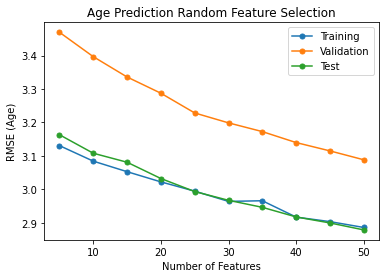

In [46]:
import matplotlib.pyplot as plt

train = (np.sum(topRMSE[:,:,0], axis=0)/10)**0.5/12
bestVal = np.sum(topRMSE[:,:,1], axis=0)/10/12
testNoVal = np.sum(topRMSE[:,:,2], axis=0)/10/12

idcs = 5*np.arange(1,11)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(idcs, train, label='Training', marker='.', markersize=10)
ax.plot(idcs, bestVal, label='Validation', marker='.', markersize=10)
ax.plot(idcs, testNoVal, label='Test', marker='.', markersize=10)

ax.legend()
ax.set_title('Age Prediction Random Feature Selection')
ax.set_xlabel('Number of Features')
ax.set_ylabel('RMSE (Age)')

fig.show()
fig.savefig('../../Work/LatentSim/RandomValidation50FeatDP5DP2.png', format='png', bbox_inches='tight')

In [47]:
with open('../../Work/LatentSim/Greed/RandomValidation50FeatDP5DP2.pkl', 'wb') as f:
    pickle.dump([topRegions, topRMSE], f)
    
print('Complete')

Complete


In [45]:
allReg = topRegions[:,0:3,:,4,0].flatten()

print(len(allReg))
print(len(np.unique(allReg)))

60
16


In [18]:
with open('../../Work/LatentSim/Greed/WratValidationDP2.pkl', 'rb') as f:
    topRegions, topRMSE = pickle.load(f)
    
print(topRMSE.shape)

(10, 10, 3)
